# Counterfactual policy simulations

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Plots

In [2]:
def change(lst):
    return np.array(lst[1:]-lst[0])

def pct_change(nom,denom):
    return (change(nom)/change(denom)-1)*100

In [3]:
def change_plot(x,y,labels,xlab,ylab,linestyle,alpha,ylim=None,lw=3,fs=15,ls=13,save=True):
    
    #prep
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    # plot
    for i in range(len(y)):
        ax.plot(x,y[i], linestyle[i], linewidth=lw, label=labels[i], marker='o', alpha=alpha[i])    
        
    # details
    ax.set_xlabel(xlab, fontsize=fs)
    ax.set_ylabel(ylab, fontsize=fs)    
    ax.legend(fontsize=ls)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    if not ylim==None:
        ax.set_ylim(ylim)
    fig.tight_layout()

    if save:
        return fig

In [24]:
def one_year_plot(x,y,labels,xlab,ylab,ylim=None,width=0.2,loc='best',fs=15,ls=13,save=True):
    
    # prep
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    # plot
    x_axis = np.arange(len(x))
    for i in range(len(y)):
        ax.bar(x_axis + i*width, y[i], width, label=labels[i])

    ax.set_xticklabels(x)
    ax.set_xlabel(xlab, fontsize=fs)
    ax.set_ylabel(ylab, fontsize=fs)    
    ax.legend(loc=loc,fontsize=ls)
    ax.tick_params(axis='both', which='major', labelsize=fs)    
    ax.set_xticks(x_axis + width + width/2)
    if not ylim==None:
        ax.set_ylim(ylim)
    fig.tight_layout()
    if save:
        return fig

# Deduction

In [5]:
CoupleEst,SingleEst = SMD.load_est(name='baseline2',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
Couple.solve()
Couple.simulate()

In [6]:
Women_old = figs.retirement_probs_c(Couple,ma=0,ages=[58,72])
Women_old['label'] = ['2008 rules']
Men_old = figs.retirement_probs_c(Couple,ma=1,ages=[58,72])
Men_old['label'] = ['2008 rules']

New rules

In [7]:
# increase OAP age
Couple.par.oap_age = 67
Couple.Single.par.oap_age = 67
Couple.par.erp_age = 62
Couple.Single.par.erp_age = 62
Couple.par.two_year = 64
Couple.Single.par.two_year = 64

# shut down ERP
Couple.par.ERP_low = 0
Couple.par.ERP_high = 0
Couple.par.ERP_2 = 0
Couple.Single.par.ERP_low = 0
Couple.Single.par.ERP_high = 0
Couple.Single.par.ERP_2 = 0

# jit
Couple.solve(recompute=True)
Couple.simulate()

In [8]:
Women_new = figs.retirement_probs_c(Couple,ma=0,ages=[58,72])
Women_new['label'] = ['New rules']
Men_new = figs.retirement_probs_c(Couple,ma=1,ages=[58,72])
Men_new['label'] = ['New rules']

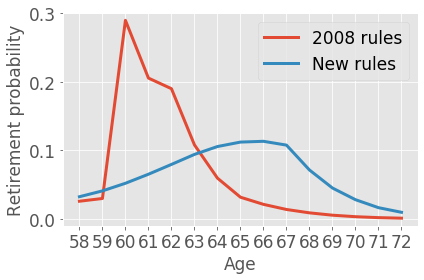

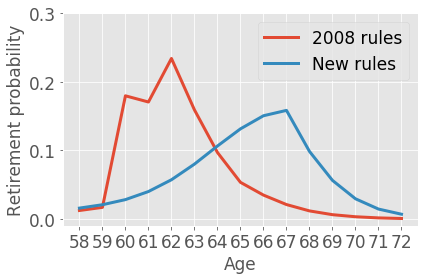

In [9]:
figs.MyPlot([Women_old,Women_new],ylim=[-0.01,0.3],linewidth=3).savefig('figs/Experiments/DeductionWomen2.png')
figs.MyPlot([Men_old,Men_new],ylim=[-0.01,0.3],linewidth=3).savefig('figs/Experiments/DeductionMen2.png')

### Introduce deduction in new rules

In [10]:
x = np.linspace(0,2,11)
GovS = {}

In [11]:
GovS['68'] = figs.resolve_c(Couple, vars=['GovS', 'd', 'RetAge'], fradrag=x)
Couple.par.fradrag_to_oap = 0
GovS['67'] = figs.resolve_c(Couple, vars=['GovS', 'd', 'RetAge'], fradrag=x)
Couple.par.fradrag_to_oap = -1
GovS['66'] = figs.resolve_c(Couple, vars=['GovS', 'd', 'RetAge'], fradrag=x)
Couple.par.fradrag_to_oap = -2
GovS['65'] = figs.resolve_c(Couple, vars=['GovS', 'd', 'RetAge'], fradrag=x)
Couple.par.fradrag_to_oap = -3
GovS['64'] = figs.resolve_c(Couple, vars=['GovS', 'd', 'RetAge'], fradrag=x)

### Labor supply and government surplus

In [12]:
d64 = np.zeros(len(x))
d65 = np.zeros(len(x))
d66 = np.zeros(len(x))
d67 = np.zeros(len(x))
d68 = np.zeros(len(x))
for i in range(len(x)):
    d64[i] = np.sum(GovS['64']['couple']['d'][i]['base'])
    d65[i] = np.sum(GovS['65']['couple']['d'][i]['base'])
    d66[i] = np.sum(GovS['66']['couple']['d'][i]['base'])
    d67[i] = np.sum(GovS['67']['couple']['d'][i]['base'])
    d68[i] = np.sum(GovS['68']['couple']['d'][i]['base'])

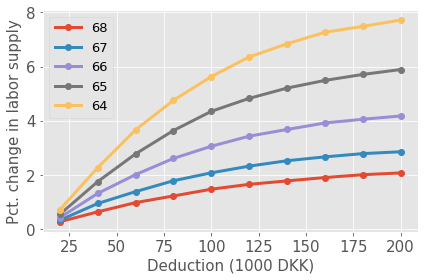

In [13]:
N = Couple.par.simN
labels = ['68', '67', '66', '65', '64']
ylab = 'Pct. change in labor supply'
xlab = 'Deduction (1000 DKK)'
linestyle = ['-', '-', '-', '-', '-']
alpha = [1,1,1,1,1]
y = [(d68[1:]/d68[0]-1)*100, (d67[1:]/d67[0]-1)*100, (d66[1:]/d66[0]-1)*100, (d65[1:]/d65[0]-1)*100, (d64[1:]/d64[0]-1)*100]
change_plot(x[1:]*100,y,labels,xlab,ylab,linestyle,alpha).savefig('figs/Experiments/DeductionSupply2.png')

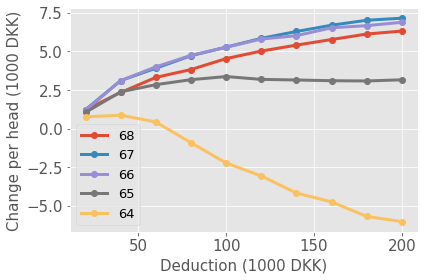

In [14]:
N = Couple.par.simN
labels = ['68', '67', '66', '65', '64']
ylab = 'Change per head (1000 DKK)'
xlab = 'Deduction (1000 DKK)'
linestyle = ['-', '-', '-', '-', '-']
alpha = [1,1,1,1,1]
y = [change(GovS['68']['couple']['GovS'])*100/(2*N), change(GovS['67']['couple']['GovS'])*100/(2*N),
     change(GovS['66']['couple']['GovS'])*100/(2*N), change(GovS['65']['couple']['GovS'])*100/(2*N),
     change(GovS['64']['couple']['GovS'])*100/(2*N)]
change_plot(x[1:]*100,y,labels,xlab,ylab,linestyle,alpha).savefig('figs/Experiments/DeductionSurplus2.png')

# Retirement age

In [15]:
LL = {}
GG = {}
age = (65,62,60)
ages_dict_one = {'oap_age':   [i+age[0] for i in range(2)],
                 'two_year':  [i+age[1] for i in range(2)],
                 'erp_age':   [i+age[2] for i in range(2)]}
ages_dict = {'oap_age':   [i+age[0] for i in range(7)],
             'two_year':  [i+age[1] for i in range(7)],
             'erp_age':   [i+age[2] for i in range(7)]}

### Baseline

In [16]:
CoupleEst,SingleEst = SMD.load_est(name='baseline2',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LL['baseline'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], **ages_dict_one)
GG['baseline'] = figs.resolve_c(Couple, vars=['d', 'GovS', 'RetAge'], **ages_dict)

### phi=0 (re-estimated)

In [17]:
CoupleEst,SingleEst = SMD.load_est(name='phi0',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LL['phi0'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], **ages_dict_one)
GG['phi0'] = figs.resolve_c(Couple, vars=['d', 'GovS', 'RetAge'], **ages_dict)

### phi high

In [18]:
CoupleEst,SingleEst = SMD.load_est(name='phi_high',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LL['phi_high'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], **ages_dict_one)
GG['phi_high'] = figs.resolve_c(Couple, vars=['d', 'GovS', 'RetAge'], **ages_dict)

### phi=0 (not re-estimated)

In [19]:
Couple.par.phi_0_male = 0
Couple.par.phi_0_female = 0
LL['phi0_not'] = figs.resolve_c(Couple, vars=['d', 'RetAge', 'probs'], **ages_dict_one)
GG['phi0_not'] = figs.resolve_c(Couple, vars=['d', 'GovS', 'RetAge'], **ages_dict)

### Predicted average retirement age

Men

In [20]:
print('baseline                :', np.round(LL['baseline']['couple']['RetAge'][0]['base_m'],2))
print('single                  :', np.round(LL['baseline']['single']['RetAge'][0]['base_m'],2))
print('phi=0                   :', np.round(LL['phi0']['couple']['RetAge'][0]['base_m'],2))
print('phi high                :', np.round(LL['phi_high']['couple']['RetAge'][0]['base_m'],2))
print('phi=0 (not re-estimated):', np.round(LL['phi0_not']['couple']['RetAge'][0]['base_m'],2))

baseline                : 62.2
single                  : 62.33
phi=0                   : 62.58
phi high                : 61.76
phi=0 (not re-estimated): 64.67


Women

In [21]:
print('baseline                :', np.round(LL['baseline']['couple']['RetAge'][0]['base_f'],2))
print('single                  :', np.round(LL['baseline']['single']['RetAge'][0]['base_f'],2))
print('phi=0                   :', np.round(LL['phi0']['couple']['RetAge'][0]['base_f'],2))
print('phi high                :', np.round(LL['phi_high']['couple']['RetAge'][0]['base_f'],2))
print('phi=0 (not re-estimated):', np.round(LL['phi0_not']['couple']['RetAge'][0]['base_f'],2))

baseline                : 61.35
single                  : 61.64
phi=0                   : 61.75
phi high                : 60.15
phi=0 (not re-estimated): 61.82


### Plots

In [22]:
# read in computed quantities
#GG = np.load('old_estimates/GovS.npy',allow_pickle='TRUE').item()
#LL = np.load('old_estimates/LS.npy',allow_pickle='TRUE').item()

### Retirement probabilities - one year increase

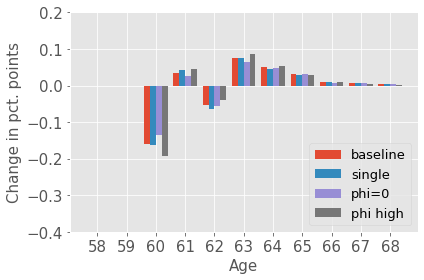

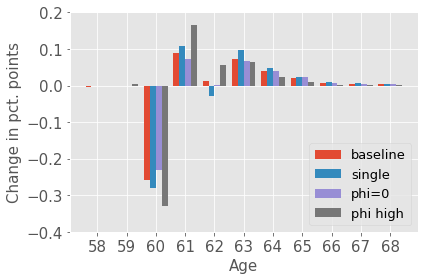

In [25]:
ym = [LL['baseline']['couple']['probs'][1]['base_m']['y'][0]-LL['baseline']['couple']['probs'][0]['base_m']['y'][0],
      LL['baseline']['single']['probs'][1]['base_m']['y'][0]-LL['baseline']['single']['probs'][0]['base_m']['y'][0],
      LL['phi0']['couple']['probs'][1]['base_m']['y'][0]-LL['phi0']['couple']['probs'][0]['base_m']['y'][0],
      LL['phi_high']['couple']['probs'][1]['base_m']['y'][0]-LL['phi_high']['couple']['probs'][0]['base_m']['y'][0]]
yf = [LL['baseline']['couple']['probs'][1]['base_f']['y'][0]-LL['baseline']['couple']['probs'][0]['base_f']['y'][0],
      LL['baseline']['single']['probs'][1]['base_f']['y'][0]-LL['baseline']['single']['probs'][0]['base_f']['y'][0],
      LL['phi0']['couple']['probs'][1]['base_f']['y'][0]-LL['phi0']['couple']['probs'][0]['base_f']['y'][0],
      LL['phi_high']['couple']['probs'][1]['base_f']['y'][0]-LL['phi_high']['couple']['probs'][0]['base_f']['y'][0]]
x = np.arange(58,69)
xlab = 'Age'
ylab = 'Change in pct. points'
labels = ['baseline', 'single', 'phi=0', 'phi high']
one_year_plot(x,ym,labels,xlab,ylab,ylim=[-0.4,0.2],loc=4).savefig('figs/Experiments/RASurplusMen2.png')
one_year_plot(x,yf,labels,xlab,ylab,ylim=[-0.4,0.2],loc=4).savefig('figs/Experiments/RASurplusWomen2.png')

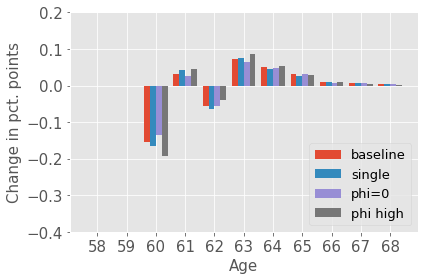

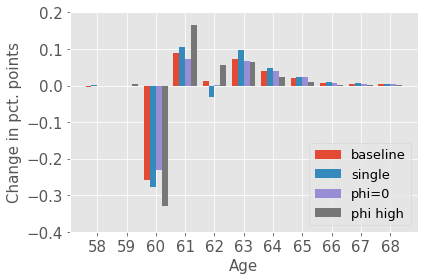

In [59]:
ym = [LS['baseline']['couple']['probs'][1]['base_m']['y'][0]-LS['baseline']['couple']['probs'][0]['base_m']['y'][0],
      LS['baseline']['single']['probs'][1]['base_m']['y'][0]-LS['baseline']['single']['probs'][0]['base_m']['y'][0],
      LS['phi0']['couple']['probs'][1]['base_m']['y'][0]-LS['phi0']['couple']['probs'][0]['base_m']['y'][0],
      LS['phi_high']['couple']['probs'][1]['base_m']['y'][0]-LS['phi_high']['couple']['probs'][0]['base_m']['y'][0]]
yf = [LS['baseline']['couple']['probs'][1]['base_f']['y'][0]-LS['baseline']['couple']['probs'][0]['base_f']['y'][0],
      LS['baseline']['single']['probs'][1]['base_f']['y'][0]-LS['baseline']['single']['probs'][0]['base_f']['y'][0],
      LS['phi0']['couple']['probs'][1]['base_f']['y'][0]-LS['phi0']['couple']['probs'][0]['base_f']['y'][0],
      LS['phi_high']['couple']['probs'][1]['base_f']['y'][0]-LS['phi_high']['couple']['probs'][0]['base_f']['y'][0]]
x = np.arange(58,69)
xlab = 'Age'
ylab = 'Change in pct. points'
labels = ['baseline', 'single', 'phi=0', 'phi high']
one_year_plot(x,ym,labels,xlab,ylab,loc=4).savefig('figs/Experiments/RASurplusMen.png')
one_year_plot(x,yf,labels,xlab,ylab,loc=4).savefig('figs/Experiments/RASurplusWomen.png')

### Goverment surplus

In [26]:
# factor to account for the fact that we simulate more married individuals than singles
factor = np.count_nonzero(~np.isnan(Couple.sim.d))/np.count_nonzero(~np.isnan(Couple.Single.sim.d))

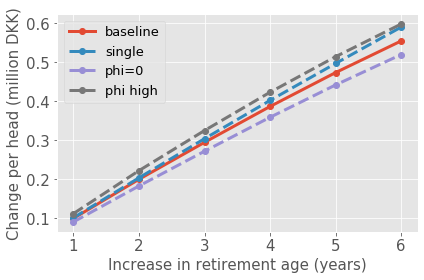

In [28]:
N = Couple.par.simN
labels = ['baseline', 'single', 'phi=0', 'phi high']
ylab = 'Change per head (million DKK)'
xlab = 'Increase in retirement age (years)'
linestyle = ['-', '--', '--', '--']
alpha = [1,1,1,1]
x = np.arange(1,7)
y = [change(GG['baseline']['couple']['GovS'])/(10*2*N), change(GG['baseline']['single']['GovS'])/(10*factor*N),
     change(GG['phi0']['couple']['GovS'])/(10*2*N), change(GG['phi_high']['couple']['GovS'])/(10*2*N)]
change_plot(x,y,labels,xlab,ylab,linestyle,alpha).savefig('figs/Experiments/RASurplus2.png')

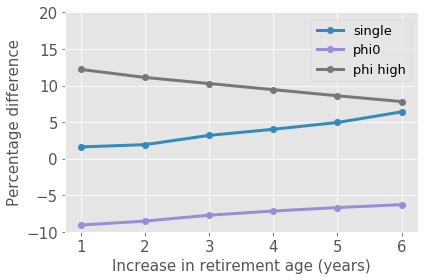

In [29]:
labels = [None, 'single', 'phi0', 'phi high']
ylab = 'Percentage difference'
linestyle = ['-','-','-','-']
y_pct = [(y[1]/y[0]-1)*100, (y[1]/y[0]-1)*100, (y[2]/y[0]-1)*100, (y[3]/y[0]-1)*100]
alpha[0] = 0
change_plot(x,y_pct,labels,xlab,ylab,linestyle,alpha,ylim=[-10,20]).savefig('figs/Experiments/RASurplus_pct2.png')

### Replicate the plot in Jorgensen (2014)

In [30]:
print('phi high                :', np.round(LL['phi_high']['couple']['RetAge'][0]['base'],2))
print('phi=0 (not re-estimated):', np.round(LL['phi0_not']['couple']['RetAge'][0]['base'],2))

phi high                : 60.95
phi=0 (not re-estimated): 63.2


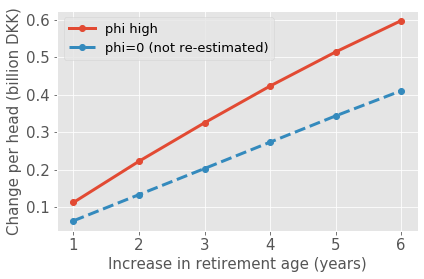

In [55]:
N = Couple.par.simN
labels = ['phi high', 'phi=0 (not re-estimated)']
ylab = 'Change per head (mio. DKK)'
xlab = 'Increase in retirement age (years)'
linestyle = ['-', '--']
alpha = [1,1]
x = np.arange(1,7)
y = [change(GovS['phi_high']['couple']['GovS'])/(20*N), change(GovS['phi0_not']['couple']['GovS'])/(20*N)]
change_plot(x,y,labels,xlab,ylab,linestyle,alpha).savefig('figs/Experiments/Thomas.png')

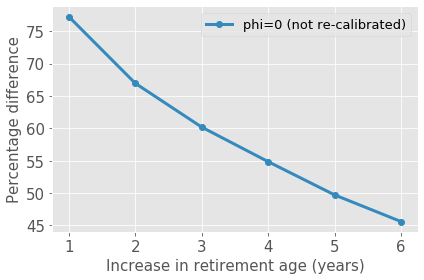

In [33]:
labels = [None, 'phi=0 (not re-calibrated)']
ylab = 'Percentage difference'
y = [change(GG['phi_high']['couple']['GovS'])/(20*N), change(GG['phi0_not']['couple']['GovS'])/(20*N)]
y_pct = [(y[0]/y[1]-1)*100, (y[0]/y[1]-1)*100]
linestyle[1] = '-'
alpha[0] = 0
change_plot(x,y_pct,labels,xlab,ylab,linestyle,alpha).savefig('figs/Experiments/Thomas_pct2.png')